In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from google.colab import files
from IPython.display import Image, display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import shutil
import PIL
import math
import glob
import json
import os
!apt-get update && apt-get -qq install xxd

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease [18.1 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [50.4 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,617 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-update

In [ ]:
# Define filenames and set up directory structure
MODELS_DIR = 'models'
if not os.path.exists(MODELS_DIR):
  os.mkdir(MODELS_DIR)
SAVED_MODEL_FILENAME = os.path.join(MODELS_DIR, "magic_wand")
FLOAT_TFL_MODEL_FILENAME = os.path.join(MODELS_DIR, "magic_wand_float.tfl")
QUANTIZED_TFL_MODEL_FILENAME = os.path.join(MODELS_DIR, "magic_wand.tfl")
TFL_CC_MODEL_FILENAME = os.path.join(MODELS_DIR, "magic_wand.cc")

DATASET_DIR =  'dataset'
if not os.path.exists(DATASET_DIR):
  os.mkdir(DATASET_DIR)
TRAIN_DIR = os.path.join(DATASET_DIR, "train")
VAL_DIR = os.path.join(DATASET_DIR, "validation")
TEST_DIR = os.path.join(DATASET_DIR, "test")
!rm -rf sample_data

CHKPT_DIR =  'checkpoints'
if not os.path.exists(CHKPT_DIR):
  os.mkdir(CHKPT_DIR)

In [ ]:
# Train Split
TEST_PERCENTAGE = 10
VALIDATION_PERCENTAGE = 10
TRAIN_PERCENTAGE = 100 - (TEST_PERCENTAGE + VALIDATION_PERCENTAGE)

In [ ]:
# Upload your files
os.chdir("/content/dataset")
uploaded = files.upload()
os.chdir("/content")

Saving wanddata.json to wanddata.json


In [ ]:
NUM_GESTURES = 3 # UPDATE THIS WITH THE NUMBER OF UNIQUE GESTURES IN YOUR DATASET #

In [ ]:
dataset_jsons = DATASET_DIR + "/*.json"
strokes = []
for filename in glob.glob(dataset_jsons):
  with open(filename, "r") as file:
    file_contents = file.read()
  file_data = json.loads(file_contents)
  for stroke in file_data["strokes"]:
    stroke["filename"] = filename
    strokes.append(stroke)

In [ ]:
# Helper function to visualize the data
def plot_stroke(stroke):
  x_array = []
  y_array = []
  for coords in stroke["strokePoints"]:
    x_array.append(coords["x"])
    y_array.append(coords["y"])

  fig = plt.figure(figsize=(12.8, 4.8))
  fig.suptitle(stroke["label"])

  ax = fig.add_subplot(131)
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_xlim(-0.4, 0.4)
  ax.set_ylim(-0.4, 0.4)
  ax.plot(x_array, y_array)

  plt.show()

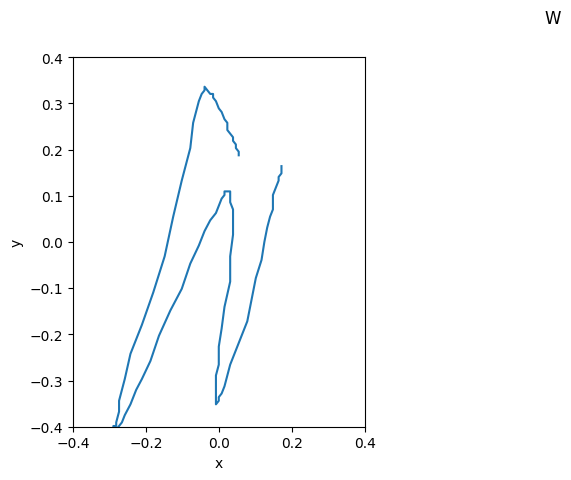

In [ ]:
# Display a stroke from the strokes python variable
plot_stroke(strokes[11])

In [ ]:

FIXED_POINT = 256

def mul_fp(a, b):
  return (a * b) / FIXED_POINT

def div_fp(a, b):
  if b == 0:
    b = 1
  return (a * FIXED_POINT) / b

def float_to_fp(a):
  return math.floor(a * FIXED_POINT)

def norm_to_coord_fp(a, range_fp, half_size_fp):
  a_fp = float_to_fp(a)
  norm_fp = div_fp(a_fp, range_fp)
  return mul_fp(norm_fp, half_size_fp) + half_size_fp

def round_fp_to_int(a):
  return math.floor((a + (FIXED_POINT / 2)) / FIXED_POINT)

def gate(a, min, max):
  if a < min:
    return min
  elif a > max:
    return max
  else:
    return a

def rasterize_stroke(stroke_points, x_range, y_range, width, height):
  num_channels = 3
  buffer_byte_count = height * width * num_channels
  buffer = bytearray(buffer_byte_count)

  width_fp = width * FIXED_POINT
  height_fp = height * FIXED_POINT
  half_width_fp = width_fp / 2
  half_height_fp = height_fp / 2
  x_range_fp = float_to_fp(x_range)
  y_range_fp = float_to_fp(y_range)

  t_inc_fp = FIXED_POINT / len(stroke_points)

  one_half_fp = (FIXED_POINT / 2)

  for point_index in range(len(stroke_points) - 1):
    start_point = stroke_points[point_index]
    end_point = stroke_points[point_index + 1]
    start_x_fp = norm_to_coord_fp(start_point["x"], x_range_fp, half_width_fp)
    start_y_fp = norm_to_coord_fp(-start_point["y"], y_range_fp, half_height_fp)
    end_x_fp = norm_to_coord_fp(end_point["x"], x_range_fp, half_width_fp)
    end_y_fp = norm_to_coord_fp(-end_point["y"], y_range_fp, half_height_fp)
    delta_x_fp = end_x_fp - start_x_fp
    delta_y_fp = end_y_fp - start_y_fp

    t_fp = point_index * t_inc_fp
    if t_fp < one_half_fp:
      local_t_fp = div_fp(t_fp, one_half_fp)
      one_minus_t_fp = FIXED_POINT - local_t_fp
      red = round_fp_to_int(one_minus_t_fp * 255)
      green = round_fp_to_int(local_t_fp * 255)
      blue = 0
    else:
      local_t_fp = div_fp(t_fp - one_half_fp, one_half_fp)
      one_minus_t_fp = FIXED_POINT - local_t_fp
      red = 0
      green = round_fp_to_int(one_minus_t_fp * 255)
      blue = round_fp_to_int(local_t_fp * 255)
    red = gate(red, 0, 255)
    green = gate(green, 0, 255)
    blue = gate(blue, 0, 255)

    if abs(delta_x_fp) > abs(delta_y_fp):
      line_length = abs(round_fp_to_int(delta_x_fp))
      if delta_x_fp > 0:
        x_inc_fp = 1 * FIXED_POINT
        y_inc_fp = div_fp(delta_y_fp, delta_x_fp)
      else:
        x_inc_fp = -1 * FIXED_POINT
        y_inc_fp = -div_fp(delta_y_fp, delta_x_fp)
    else:
      line_length = abs(round_fp_to_int(delta_y_fp))
      if delta_y_fp > 0:
        y_inc_fp = 1 * FIXED_POINT
        x_inc_fp = div_fp(delta_x_fp, delta_y_fp)
      else:
        y_inc_fp = -1 * FIXED_POINT
        x_inc_fp = -div_fp(delta_x_fp, delta_y_fp)
    for i in range(line_length + 1):
      x_fp = start_x_fp + (i * x_inc_fp)
      y_fp = start_y_fp + (i * y_inc_fp)
      x = round_fp_to_int(x_fp)
      y = round_fp_to_int(y_fp)
      if (x < 0) or (x >= width) or (y < 0) or (y >= height):
        continue
      buffer_index = (y * width * num_channels) + (x * num_channels)
      buffer[buffer_index + 0] = red
      buffer[buffer_index + 1] = green
      buffer[buffer_index + 2] = blue

  np_buffer = np.frombuffer(buffer, dtype=np.uint8).reshape(height, width, num_channels)

  return np_buffer

In [ ]:
X_RANGE = 0.6
Y_RANGE = 0.6

def ensure_empty_dir(dirname):
  dirpath = Path(dirname)
  if dirpath.exists() and dirpath.is_dir():
    shutil.rmtree(dirpath)
  dirpath.mkdir()

def augment_points(points, move_range, scale_range, rotate_range):
  move_x = np.random.uniform(low=-move_range, high=move_range)
  move_y = np.random.uniform(low=-move_range, high=move_range)
  scale = np.random.uniform(low=1.0-scale_range, high=1.0+scale_range)
  rotate = np.random.uniform(low=-rotate_range, high=rotate_range)

  x_axis_x = math.cos(rotate) * scale
  x_axis_y = math.sin(rotate) * scale

  y_axis_x = -math.sin(rotate) * scale
  y_axis_y = math.cos(rotate) * scale

  new_points = []
  for point in points:
    old_x = point["x"]
    old_y = point["y"]
    new_x = (x_axis_x * old_x) + (x_axis_y * old_y) + move_x
    new_y = (y_axis_x * old_x) + (y_axis_y * old_y) + move_y
    new_points.append({"x": new_x, "y": new_y})

  return new_points

def save_strokes_as_images(strokes, root_folder, width, height, augment_count):
  ensure_empty_dir(root_folder)
  labels = set()
  for stroke in strokes:
    labels.add(stroke["label"].lower())
  for label in labels:
    label_path = Path(root_folder, label)
    ensure_empty_dir(label_path)

  label_counts = {}
  for stroke in strokes:
    points = stroke["strokePoints"]
    label = stroke["label"].lower()
    if label == "":
      raise Exception("Missing label for %s:%d" % (stroke["filename"], stroke["index"]))
    if label not in label_counts:
      label_counts[label] = 0
    label_count = label_counts[label]
    label_counts[label] += 1
    raster = rasterize_stroke(points, X_RANGE, Y_RANGE, width, height)
    image = PIL.Image.fromarray(raster)
    image.save(Path(root_folder, label, str(label_count) + ".png"))
    for i in range(augment_count):
      augmented_points = augment_points(points, 0.1, 0.1, 0.3)
      raster = rasterize_stroke(augmented_points, X_RANGE, Y_RANGE, width, height)
      image = PIL.Image.fromarray(raster)
      image.save(Path(root_folder, label, str(label_count) + "_a" + str(i) + ".png"))
  return labels


In [ ]:
strokes = [stroke for stroke in strokes if 'label' in stroke and stroke['label'] != '']


In [ ]:
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32

shuffled_strokes = strokes
np.random.shuffle(shuffled_strokes)

test_count = math.floor((len(shuffled_strokes) * TEST_PERCENTAGE) / 100)
validation_count = math.floor((len(shuffled_strokes) * VALIDATION_PERCENTAGE) / 100)
test_strokes = shuffled_strokes[0:test_count]
validation_strokes = shuffled_strokes[test_count:(test_count + validation_count)]
train_strokes = shuffled_strokes[(test_count + validation_count):]

labels_test  = save_strokes_as_images(test_strokes, TEST_DIR, IMAGE_WIDTH, IMAGE_HEIGHT, 10)
labels_val   = save_strokes_as_images(validation_strokes, VAL_DIR, IMAGE_WIDTH, IMAGE_HEIGHT, 0)
labels_train = save_strokes_as_images(train_strokes, TRAIN_DIR, IMAGE_WIDTH, IMAGE_HEIGHT, 10)

In [ ]:
labels = sorted(labels_test.union(labels_val).union(labels_train))
# get the conversion from label string to int
labelToInt = {}
currInt = 0
for label in labels:
  labelToInt[label] = currInt
  currInt = currInt + 1
intToLabel = {v: k for k, v in labelToInt.items()}
print(intToLabel)


{0: 'l', 1: 'o', 2: 'w'}


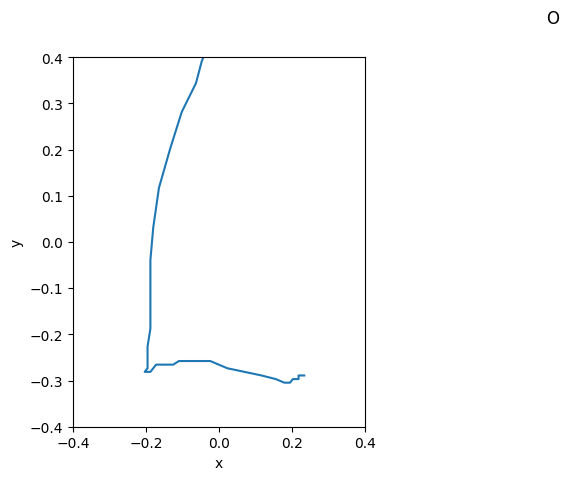

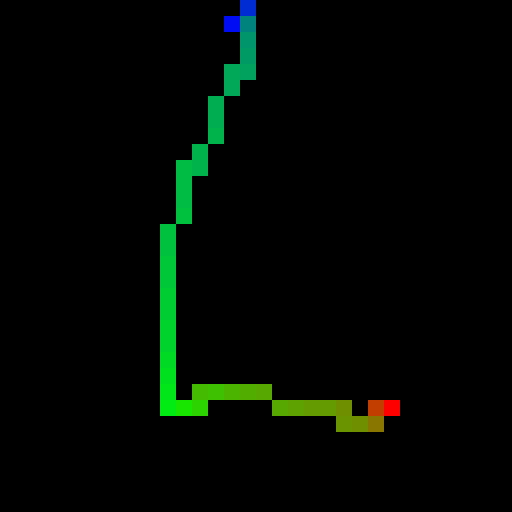

In [ ]:
"""If you'd like to visualize the difference between a stroke and its rasterized output image, run the cell below!"""

plot_stroke(strokes[0])
raster = rasterize_stroke(strokes[0]["strokePoints"], 0.5, 0.5, 32, 32)
PIL.Image.fromarray(raster).resize((512, 512), PIL.Image.NEAREST)

Found 18 files belonging to 3 classes.
Found 1595 files belonging to 3 classes.


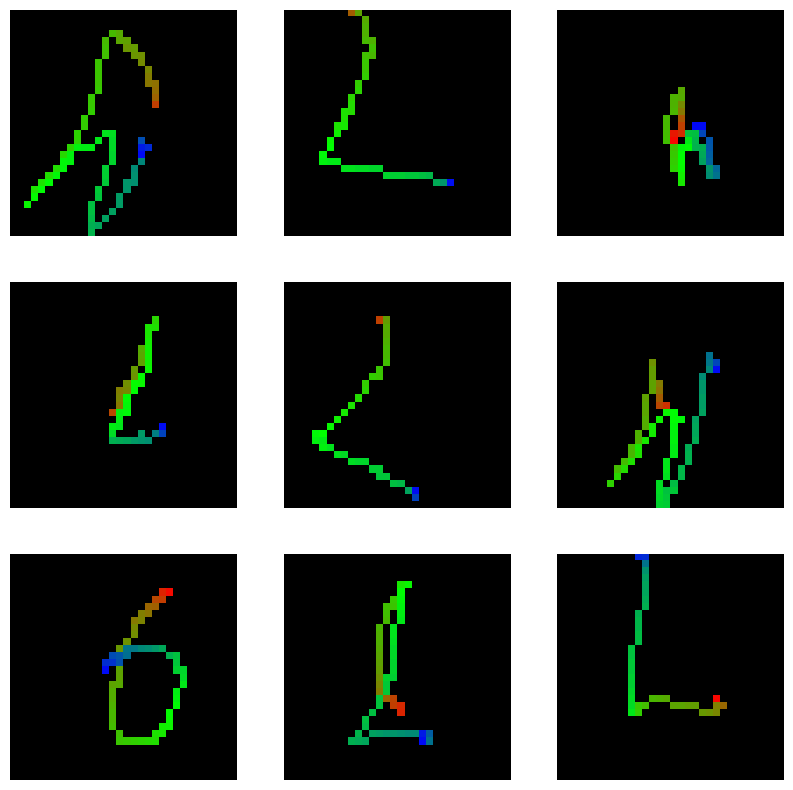

In [ ]:
"""Finally, we'll generate a dataset in ```Keras```."""

validation_ds = image_dataset_from_directory(
    directory=VAL_DIR,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT)).prefetch(buffer_size=32)

train_ds = image_dataset_from_directory(
    directory=TRAIN_DIR,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT)).prefetch(buffer_size=32)

# Plot 9 of our final dataset items
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(16, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.5)(x)

    x = layers.GlobalAveragePooling2D()(x)
    activation = "softmax"
    units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), num_classes=NUM_GESTURES)


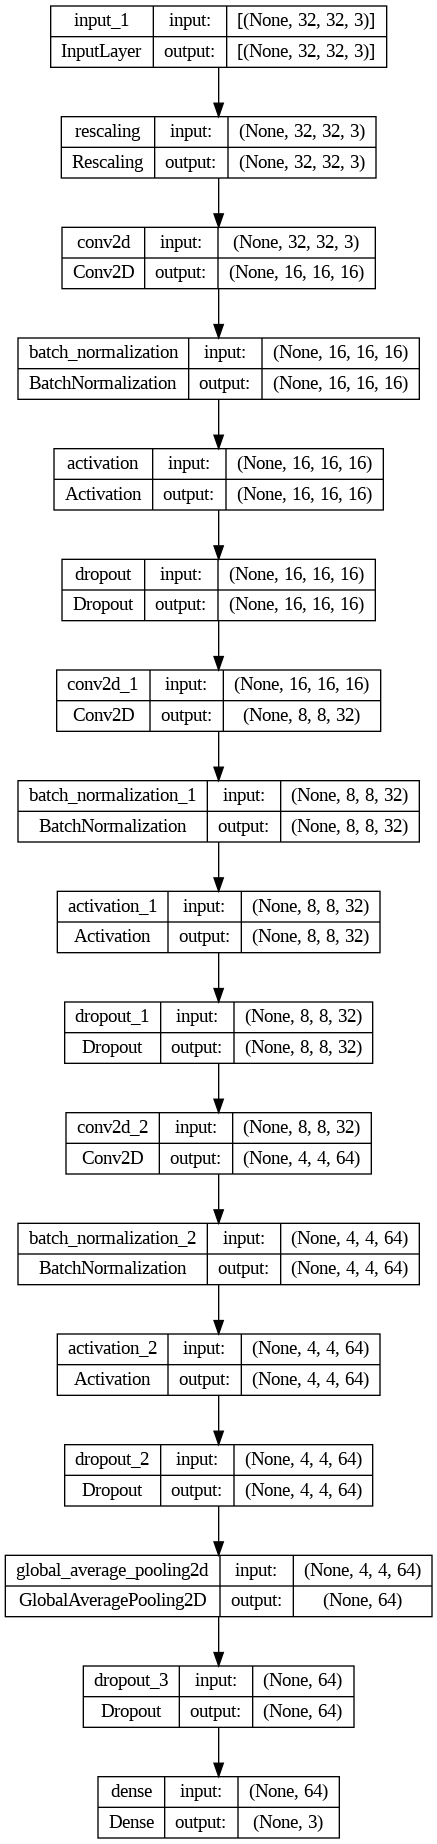

In [ ]:
# View the model layers as a diagram
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# How many epochs to train for, we have found ~30 to be a good starting point
EPOCHS = 30

# Callback to save model checkpoints for future inspection or training
checkpointFileLoc = CHKPT_DIR + "/save_at_{epoch:02d}.h5"
modelCheckpointCallback = keras.callbacks.ModelCheckpoint(checkpointFileLoc)

# Compile the model!
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [ ]:
# Run training
history = model.fit(train_ds, epochs=EPOCHS, validation_data=validation_ds,
                    callbacks=[modelCheckpointCallback])

Epoch 1/30
50/50 [==============================] - 3s 25ms/step - loss: 0.6522 - accuracy: 0.4251 - val_loss: 0.6627 - val_accuracy: 0.3333


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/30
50/50 [==============================] - 1s 28ms/step - loss: 0.6014 - accuracy: 0.5085 - val_loss: 0.7112 - val_accuracy: 0.3333
Epoch 3/30
50/50 [==============================] - 1s 20ms/step - loss: 0.5674 - accuracy: 0.5442 - val_loss: 0.7956 - val_accuracy: 0.3333
Epoch 4/30
50/50 [==============================] - 1s 20ms/step - loss: 0.5501 - accuracy: 0.5799 - val_loss: 0.8501 - val_accuracy: 0.3333
Epoch 5/30
50/50 [==============================] - 1s 23ms/step - loss: 0.5355 - accuracy: 0.5987 - val_loss: 0.8789 - val_accuracy: 0.3333
Epoch 6/30
50/50 [==============================] - 2s 34ms/step - loss: 0.5221 - accuracy: 0.6138 - val_loss: 0.8478 - val_accuracy: 0.3333
Epoch 7/30
50/50 [==============================] - 1s 20ms/step - loss: 0.4968 - accuracy: 0.6414 - val_loss: 0.7933 - val_accuracy: 0.3333
Epoch 8/30
50/50 [==============================] - 1s 20ms/step - loss: 0.4924 - accuracy: 0.6458 - val_loss: 0.7120 - val_accuracy: 0.3889
Epoch 9/30
50

In [ ]:
# Run training
history = model.fit(train_ds, epochs=EPOCHS, validation_data=validation_ds,
                    callbacks=[modelCheckpointCallback])

Epoch 1/30
50/50 [==============================] - 1s 25ms/step - loss: 0.3786 - accuracy: 0.7467 - val_loss: 0.6483 - val_accuracy: 0.5556
Epoch 2/30
50/50 [==============================] - 1s 27ms/step - loss: 0.3852 - accuracy: 0.7386 - val_loss: 0.5141 - val_accuracy: 0.6111
Epoch 3/30
50/50 [==============================] - 1s 20ms/step - loss: 0.3873 - accuracy: 0.7404 - val_loss: 0.6527 - val_accuracy: 0.6111
Epoch 4/30
50/50 [==============================] - 1s 20ms/step - loss: 0.3640 - accuracy: 0.7636 - val_loss: 0.4322 - val_accuracy: 0.6111
Epoch 5/30
50/50 [==============================] - 1s 19ms/step - loss: 0.3712 - accuracy: 0.7498 - val_loss: 0.4229 - val_accuracy: 0.5556
Epoch 6/30
50/50 [==============================] - 1s 18ms/step - loss: 0.3788 - accuracy: 0.7442 - val_loss: 0.3561 - val_accuracy: 0.7778
Epoch 7/30
50/50 [==============================] - 1s 20ms/step - loss: 0.3663 - accuracy: 0.7605 - val_loss: 0.3587 - val_accuracy: 0.7778
Epoch 8/30
50

In [ ]:
# save the model file
model.save(SAVED_MODEL_FILENAME)

Testing Gesture:  l  with datasize:  77
1/1 [==============================] - 0s 20ms/step
l 2 0.9999994
[l] expected, [w] found with score [0.999999]


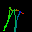

1/1 [==============================] - 0s 22ms/step
l 2 0.9999918
[l] expected, [w] found with score [0.999992]


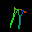

1/1 [==============================] - 0s 21ms/step
l 2 0.99997985
[l] expected, [w] found with score [0.999980]


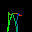

1/1 [==============================] - 0s 22ms/step
l 2 0.9999981
[l] expected, [w] found with score [0.999998]


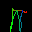

1/1 [==============================] - 0s 33ms/step
l 2 0.99999106
[l] expected, [w] found with score [0.999991]


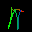

1/1 [==============================] - 0s 47ms/step
l 2 0.9999924
[l] expected, [w] found with score [0.999992]


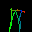

1/1 [==============================] - 0s 20ms/step
l 2 0.9998437
[l] expected, [w] found with score [0.999844]


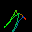

1/1 [==============================] - 0s 20ms/step
l 2 0.9998043
[l] expected, [w] found with score [0.999804]


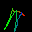

1/1 [==============================] - 0s 21ms/step
l 2 0.9999999
[l] expected, [w] found with score [1.000000]


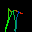

1/1 [==============================] - 0s 26ms/step
l 2 0.9999994
[l] expected, [w] found with score [0.999999]


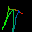

1/1 [==============================] - 0s 25ms/step
l 2 0.99990094
[l] expected, [w] found with score [0.999901]


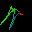

1/1 [==============================] - 0s 24ms/step
Testing Gesture:  w  with datasize:  55
1/1 [==============================] - 0s 20ms/step
w 0 0.9101928
[w] expected, [l] found with score [0.910193]


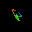

1/1 [==============================] - 0s 20ms/step
w 0 0.7971336
[w] expected, [l] found with score [0.797134]


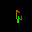

1/1 [==============================] - 0s 19ms/step
w 0 0.8794106
[w] expected, [l] found with score [0.879411]


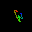

1/1 [==============================] - 0s 21ms/step
w 0 0.84442353
[w] expected, [l] found with score [0.844424]


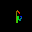

1/1 [==============================] - 0s 20ms/step
w 0 0.8280253
[w] expected, [l] found with score [0.828025]


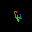

1/1 [==============================] - 0s 19ms/step
w 0 0.8140753
[w] expected, [l] found with score [0.814075]


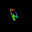

1/1 [==============================] - 0s 23ms/step
Testing Gesture:  o  with datasize:  66
1/1 [==============================] - 0s 25ms/step
o 0 0.85783076
[o] expected, [l] found with score [0.857831]


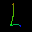

1/1 [==============================] - 0s 22ms/step
o 0 0.83699137
[o] expected, [l] found with score [0.836991]


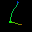

1/1 [==============================] - 0s 22ms/step
o 0 0.8077881
[o] expected, [l] found with score [0.807788]


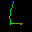

1/1 [==============================] - 0s 22ms/step
o 0 0.8694871
[o] expected, [l] found with score [0.869487]


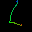

1/1 [==============================] - 0s 28ms/step
o 0 0.94871753
[o] expected, [l] found with score [0.948718]


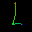

1/1 [==============================] - 0s 25ms/step
o 0 0.9286062
[o] expected, [l] found with score [0.928606]


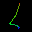

1/1 [==============================] - 0s 23ms/step
o 0 0.86625546
[o] expected, [l] found with score [0.866255]


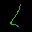

1/1 [==============================] - 0s 26ms/step
o 0 0.7812469
[o] expected, [l] found with score [0.781247]


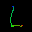

1/1 [==============================] - 0s 36ms/step
o 0 0.9030388
[o] expected, [l] found with score [0.903039]


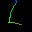

1/1 [==============================] - 0s 42ms/step
o 0 0.79459846
[o] expected, [l] found with score [0.794598]


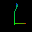

1/1 [==============================] - 0s 30ms/step
o 0 0.9401692
[o] expected, [l] found with score [0.940169]


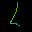

1/1 [==============================] - 0s 30ms/step
o 0 0.92057186
[o] expected, [l] found with score [0.920572]


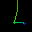

1/1 [==============================] - 0s 49ms/step
o 0 0.87209433
[o] expected, [l] found with score [0.872094]


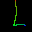

1/1 [==============================] - 0s 30ms/step
o 0 0.89749795
[o] expected, [l] found with score [0.897498]


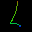

1/1 [==============================] - 0s 31ms/step
o 0 0.8863398
[o] expected, [l] found with score [0.886340]


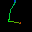

1/1 [==============================] - 0s 33ms/step
o 0 0.95064175
[o] expected, [l] found with score [0.950642]


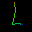

1/1 [==============================] - 0s 29ms/step
o 0 0.90319484
[o] expected, [l] found with score [0.903195]


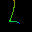

1/1 [==============================] - 0s 26ms/step
o 0 0.7979132
[o] expected, [l] found with score [0.797913]


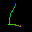

1/1 [==============================] - 0s 20ms/step
o 0 0.83622384
[o] expected, [l] found with score [0.836224]


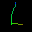

1/1 [==============================] - 0s 25ms/step
o 0 0.82839775
[o] expected, [l] found with score [0.828398]


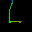

76.1% correct (N=155, 43 unknown)


In [ ]:
SCORE_THRESHOLD = 0.75 # Confidence threshold to discard an image as "unknown"

def predict_image(model, filename):
  img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)  # Create batch axis
  predictions = model.predict(img_array).flatten()
  predicted_label_index = np.argmax(predictions)
  predicted_score = predictions[predicted_label_index]
  return (predicted_label_index, predicted_score)

correct_count = 0
wrong_count = 0
discarded_count = 0
for label_dir in glob.glob(TEST_DIR + "/*"):
  label = label_dir.replace(TEST_DIR + "/", "")
  print("Testing Gesture: ",label," with datasize: ",len(glob.glob(label_dir + "/*.png")))
  for filename in glob.glob(label_dir + "/*.png"):
    index, score = predict_image(model, filename)
    if score < SCORE_THRESHOLD:
      discarded_count += 1
      continue
    if index == labelToInt[label]:
      correct_count += 1
    else:
      wrong_count += 1
      print(label,index,score)
      print("[%s] expected, [%s] found with score [%f]" % (label, intToLabel[index], score))
      display(Image(filename=filename))

if correct_count + wrong_count == 0:
  print("All images marked as unknown!")
else:
  correct_percentage = (correct_count / (correct_count + wrong_count)) * 100
  print("%.1f%% correct (N=%d, %d unknown)" % (correct_percentage, (correct_count + wrong_count), discarded_count))


In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_FILENAME)
model_no_quant_tflite = converter.convert()

In [ ]:
# Save the model to disk
open(FLOAT_TFL_MODEL_FILENAME, "wb").write(model_no_quant_tflite)

def representative_dataset():
  for filename in glob.glob(TEST_DIR + "/*/*.png"):
    img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis for images, labels in train_ds.take(1):
    yield([img_array])
# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

In [ ]:
# Save the model to disk
open(QUANTIZED_TFL_MODEL_FILENAME, "wb").write(model_tflite)

"""Compare the sizes of the Tensorflow, TensorFlow Lite and Quantized TensorFlow Lite models."""

def get_dir_size(dir):
  size = 0
  for f in os.scandir(dir):
    if f.is_file():
      size += f.stat().st_size
    elif f.is_dir():
      size += get_dir_size(f.path)
  return size



In [ ]:
# Calculate size
size_tf = get_dir_size(SAVED_MODEL_FILENAME)
size_no_quant_tflite = os.path.getsize(FLOAT_TFL_MODEL_FILENAME)
size_tflite = os.path.getsize(QUANTIZED_TFL_MODEL_FILENAME)

In [ ]:
# Compare size
pd.DataFrame.from_records(
    [["TensorFlow", f"{size_tf} bytes", ""],
     ["TensorFlow Lite", f"{size_no_quant_tflite} bytes ", f"(reduced by {size_tf - size_no_quant_tflite} bytes)"],
     ["TensorFlow Lite Quantized", f"{size_tflite} bytes", f"(reduced by {size_no_quant_tflite - size_tflite} bytes)"]],
     columns = ["Model", "Size", ""], index="Model")


,Size,
Model,,
TensorFlow,643530 bytes,
TensorFlow Lite,98692 bytes,(reduced by 544838 bytes)
TensorFlow Lite Quantized,30832 bytes,(reduced by 67860 bytes)


Testing Gesture:  l  with datasize:  77
[l] expected, [w] found with score [0.999999]


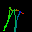

[l] expected, [w] found with score [0.999992]


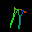

[l] expected, [w] found with score [0.999980]


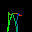

[l] expected, [w] found with score [0.999998]


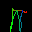

[l] expected, [w] found with score [0.999991]


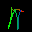

[l] expected, [w] found with score [0.999992]


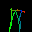

[l] expected, [w] found with score [0.999844]


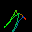

[l] expected, [w] found with score [0.999804]


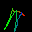

[l] expected, [w] found with score [1.000000]


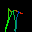

[l] expected, [w] found with score [0.999999]


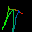

[l] expected, [w] found with score [0.999901]


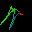

Testing Gesture:  w  with datasize:  55
[w] expected, [l] found with score [0.910193]


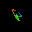

[w] expected, [l] found with score [0.797134]


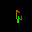

[w] expected, [l] found with score [0.879411]


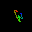

[w] expected, [l] found with score [0.844424]


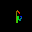

[w] expected, [l] found with score [0.828025]


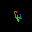

[w] expected, [l] found with score [0.814075]


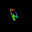

Testing Gesture:  o  with datasize:  66
[o] expected, [l] found with score [0.857831]


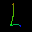

[o] expected, [l] found with score [0.836991]


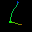

[o] expected, [l] found with score [0.807788]


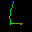

[o] expected, [l] found with score [0.869487]


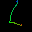

[o] expected, [l] found with score [0.948718]


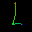

[o] expected, [l] found with score [0.928606]


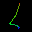

[o] expected, [l] found with score [0.866255]


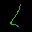

[o] expected, [l] found with score [0.781247]


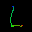

[o] expected, [l] found with score [0.903039]


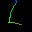

[o] expected, [l] found with score [0.794598]


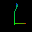

[o] expected, [l] found with score [0.940169]


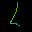

[o] expected, [l] found with score [0.920572]


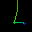

[o] expected, [l] found with score [0.872094]


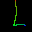

[o] expected, [l] found with score [0.897498]


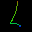

[o] expected, [l] found with score [0.886340]


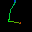

[o] expected, [l] found with score [0.950642]


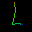

[o] expected, [l] found with score [0.903195]


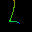

[o] expected, [l] found with score [0.797913]


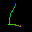

[o] expected, [l] found with score [0.836224]


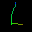

[o] expected, [l] found with score [0.828398]


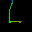

76.1% correct (N=155, 43 unknown)
Testing Gesture:  l  with datasize:  77
[l] expected, [w] found with score [0.996094]


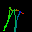

[l] expected, [w] found with score [0.996094]


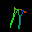

[l] expected, [w] found with score [0.996094]


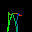

[l] expected, [w] found with score [0.996094]


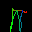

[l] expected, [w] found with score [0.996094]


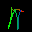

[l] expected, [w] found with score [0.996094]


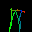

[l] expected, [w] found with score [0.996094]


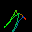

[l] expected, [w] found with score [0.996094]


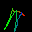

[l] expected, [w] found with score [0.996094]


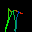

[l] expected, [w] found with score [0.996094]


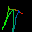

[l] expected, [w] found with score [0.996094]


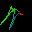

Testing Gesture:  w  with datasize:  55
[w] expected, [l] found with score [0.910156]


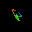

[w] expected, [l] found with score [0.816406]


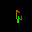

[w] expected, [l] found with score [0.882812]


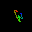

[w] expected, [l] found with score [0.855469]


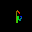

[w] expected, [l] found with score [0.839844]


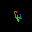

[w] expected, [l] found with score [0.753906]


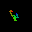

[w] expected, [l] found with score [0.828125]


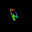

Testing Gesture:  o  with datasize:  66
[o] expected, [l] found with score [0.863281]


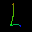

[o] expected, [l] found with score [0.847656]


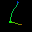

[o] expected, [l] found with score [0.808594]


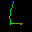

[o] expected, [l] found with score [0.875000]


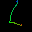

[o] expected, [l] found with score [0.953125]


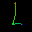

[o] expected, [l] found with score [0.929688]


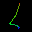

[o] expected, [l] found with score [0.867188]


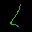

[o] expected, [l] found with score [0.789062]


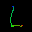

[o] expected, [l] found with score [0.910156]


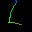

[o] expected, [l] found with score [0.804688]


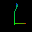

[o] expected, [l] found with score [0.941406]


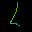

[o] expected, [l] found with score [0.921875]


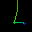

[o] expected, [l] found with score [0.871094]


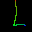

[o] expected, [l] found with score [0.898438]


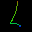

[o] expected, [l] found with score [0.890625]


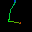

[o] expected, [l] found with score [0.957031]


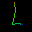

[o] expected, [l] found with score [0.753906]


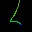

[o] expected, [l] found with score [0.902344]


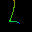

[o] expected, [l] found with score [0.808594]


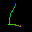

[o] expected, [l] found with score [0.843750]


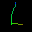

[o] expected, [l] found with score [0.835938]


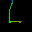

75.3% correct (N=158, 40 unknown)


"If you'd like to manually evaluate particular images you can uncomment, update, and run the below cell and select an image from the test folder."

In [ ]:
def predict_tflite(tflite_model, filename):
  img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # If required, quantize the input layer (from float to integer)
  input_scale, input_zero_point = input_details["quantization"]
  if (input_scale, input_zero_point) != (0.0, 0):
    img_array = np.multiply(img_array, 1.0 / input_scale) + input_zero_point
    img_array = img_array.astype(input_details["dtype"])

  # Invoke the interpreter
  interpreter.set_tensor(input_details["index"], img_array)
  interpreter.invoke()
  pred = interpreter.get_tensor(output_details["index"])[0]

  # If required, dequantized the output layer (from integer to float)
  output_scale, output_zero_point = output_details["quantization"]
  if (output_scale, output_zero_point) != (0.0, 0):
    pred = pred.astype(np.float32)
    pred = np.multiply((pred - output_zero_point), output_scale)

  predicted_label_index = np.argmax(pred)
  predicted_score = pred[predicted_label_index]
  return (predicted_label_index, predicted_score)

def run_tflite_test(model_file):
  correct_count = 0
  wrong_count = 0
  discarded_count = 0
  for label_dir in glob.glob(TEST_DIR + "/*"):
    label = label_dir.replace(TEST_DIR + "/", "")
    print("Testing Gesture: ",label," with datasize: ",len(glob.glob(label_dir + "/*.png")))
    for filename in glob.glob(label_dir + "/*.png"):
      index, score = predict_tflite(model_file, filename)
      if score < 0.75:
        discarded_count += 1
        continue
      if index == labelToInt[label]:
        correct_count += 1
      else:
        wrong_count += 1
        print("[%s] expected, [%s] found with score [%f]" % (label, intToLabel[index], score))
        display(Image(filename=filename))

  correct_percentage = (correct_count / (correct_count + wrong_count)) * 100

  print("%.1f%% correct (N=%d, %d unknown)" % (correct_percentage, (correct_count + wrong_count), discarded_count))

"""First test the float model."""

run_tflite_test(model_no_quant_tflite)

"""Then test the quantized model"""

run_tflite_test(model_tflite)

"""If you'd like to manually evaluate particular images you can uncomment, update, and run the below cell and select an image from the test folder."""


In [ ]:
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {QUANTIZED_TFL_MODEL_FILENAME} > {TFL_CC_MODEL_FILENAME}
# Update variable names
REPLACE_TEXT = QUANTIZED_TFL_MODEL_FILENAME.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_magic_wand_model_data/g' {TFL_CC_MODEL_FILENAME}


In [ ]:
# Print the C source file
!cat {TFL_CC_MODEL_FILENAME}
# !tail {TFL_CC_MODEL_FILENAME} # run this command to just see the end of the file (aka the size)


unsigned char g_magic_wand_model_data[] = {
  0x20, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x00, 0x00,
  0x14, 0x00, 0x20, 0x00, 0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00,
  0x1c, 0x00, 0x00, 0x00, 0x8c, 0x00, 0x00, 0x00, 0xe4, 0x00, 0x00, 0x00,
  0x80, 0x60, 0x00, 0x00, 0x90, 0x60, 0x00, 0x00, 0xd8, 0x77, 0x00, 0x00,
  0x03, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0x10, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x0a, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x08, 0x00, 0x04, 0x00,
  0x0a, 0x00, 0x00, 0x00, 0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x38, 0x00, 0x00, 0x00, 0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76,
  0x69, 0x6e, 0x67, 0x5f, 0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x9c, 0xff, 0xff, 0xff,
  0x0f, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x05, 0x00, 0x00, 0x00,
  0x64, 0x65, 0x6e, 0x73, 0x65, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 